# EPA1361 - Model-Based Decision Making
# Week 2 - Exploratory modelling and robust decision making
### Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). You might need to install [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/6.0.1/) and pip install JPype1 (for the NetLogo connector) and PySD.

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging, Constant, ScalarOutcome)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines
from ema_workbench.analysis.plotting_util import KDE


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    # Initial values
    predators, prey, sim_time = [
        np.zeros((reps, int(final_time / dt) + 1)) for _ in range(3)]

    for r in range(reps):
        predators[r, 0] = initial_predators
        prey[r, 0] = initial_prey

        # Calculate the time series
        for t in range(0, sim_time.shape[1] - 1):

            dx = (prey_birth_rate * prey[r, t]) - \
                (predation_rate * prey[r, t] * predators[r, t])
            dy = (predator_efficiency *
                  predators[r, t] * prey[r, t]) - (predator_loss_rate * predators[r, t])

            prey[r, t + 1] = max(prey[r, t] + dx * dt, 0)
            predators[r, t + 1] = max(predators[r, t] + dy * dt, 0)
            sim_time[r, t + 1] = (t + 1) * dt

    # Return outcomes
    return {'TIME': sim_time,
            'predators': predators,
            'prey': prey}

c:\users\gebruiker\anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\gebruiker\anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# 1. Load python model to ema_workbench
prey_python = Model('PredPrey', function=PredPrey)
prey_python.uncertainties = [
    RealParameter("prey_birth_rate", 0.015, 0.035),
    RealParameter("predation_rate", 0.0005, 0.003),
    RealParameter("predator_efficiency", 0.001, 0.004),
    RealParameter("predator_loss_rate", 0.04, 0.08)
]

prey_python.constants = [
    Constant("final_time", 365),
    Constant("dt", 0.25)
]

prey_python.outcomes = [
    ScalarOutcome('TIME'),
    ScalarOutcome('predators'),
    ScalarOutcome('prey')
]

In [3]:
# Import ema Vensim model
from ema_workbench.connectors.vensim import VensimModel

In [4]:
# 2. Load vensim model to ema_workbench
prey_Vensim = VensimModel("PredPreyVensim", wd=None,
                          model_file='model/PredPrey.vpm')

prey_Vensim.uncertainties = [
    RealParameter("prey_birth_rate", 0.015, 0.035),
    RealParameter("predation_rate", 0.0005, 0.003),
    RealParameter("predator_efficiency", 0.001, 0.004),
    RealParameter("predator_loss_rate", 0.04, 0.08)
]

prey_Vensim.outcomes = [
    TimeSeriesOutcome('TIME'),
    TimeSeriesOutcome('predators'),
    TimeSeriesOutcome('prey')
]

In [5]:
# import ema Netlogo model
from ema_workbench.connectors.netlogo import NetLogoModel

In [6]:
# 3. Load Netlogo model to ema_workbench
prey_Netlogo = NetLogoModel(
    'PredPreyNetlogo', model_file="model/PredPrey.nlogo")
prey_Netlogo.run_length = 365 / 0.25
prey_Netlogo.replications = 1

prey_Netlogo.uncertainties = [
    RealParameter("prey_birth_rate", 0.015, 0.035),
    RealParameter("predation_rate", 0.0005, 0.003),
    RealParameter("predator_efficiency", 0.001, 0.004),
    RealParameter("predator_loss_rate", 0.04, 0.08)
]

prey_Netlogo.outcomes = [
    TimeSeriesOutcome('TIME'),
    TimeSeriesOutcome('predators'),
    TimeSeriesOutcome('prey')
]

In [8]:
# import ema Netlogo model
from ema_workbench.connectors.excel import ExcelModel

In [9]:
# 4. Load Excel model to ema_workbench
prey_Excel = ExcelModel('PredPreyExcel', model_file="model/PredPrey.xlsx")

prey_Excel.uncertainties = [
    RealParameter("prey_birth_rate", 0.015, 0.035),
    RealParameter("predation_rate", 0.0005, 0.003),
    RealParameter("predator_efficiency", 0.001, 0.004),
    RealParameter("predator_loss_rate", 0.04, 0.08)
]

prey_Excel.outcomes = [
    TimeSeriesOutcome('TIME'),
    TimeSeriesOutcome('predators'),
    TimeSeriesOutcome('prey')
]

prey_Excel.sheet = 'Sheet1'

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [13]:
# perform experiment python
results1 = perform_experiments(prey_python, scenarios=50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished


In [12]:
# perform experiment vensim
results2 = perform_experiments(prey_Vensim, 50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished


In [11]:
# perform experiment NetLogo
results3 = perform_experiments(prey_Netlogo, 50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished


In [10]:
# perform experiment Excel
results4 = perform_experiments(prey_Excel, 50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished


In [29]:
for i in range(4):
    results = eval("results" + str(i + 1))
    print(i + 1, results[1]['TIME'].shape)

1 (50, 1, 1461)
2 (50, 1461)
3 (50, 1, 366)
4 (50, 1, 1461)


In [27]:
results1[1]['TIME'].shape

(50, 1, 1461)

In [11]:
# perform experiment for all 4
results = perform_experiments(
    [prey_Excel, prey_Netlogo, prey_python, prey_Vensim], 50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 4 model(s) = 200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished


In [11]:
# Visualize
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from ema_workbench.analysis.pairs_plotting import pairs_scatter

In [12]:
experiments, outcomes = results

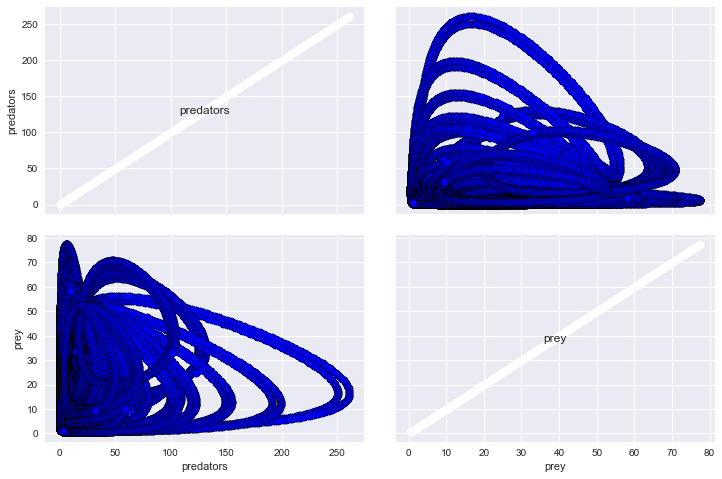

In [12]:
fig, axes = pairs_scatter(results)
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

In [13]:
experiments, outcomes = results

In [14]:
import pandas as pd

In [15]:
set(pd.DataFrame.from_records(experiments)['model'])

{'PredPrey', 'PredPreyExcel', 'PredPreyNetlogo', 'PredPreyVensim'}

In [16]:
outcomes.keys()

dict_keys(['TIME', 'predators', 'prey'])

In [73]:
# %matplotlib inline

In [18]:
outcomes2 = dict()

In [19]:
outcomes2['prey'] = outcomes['prey'][:, 0, :]

In [20]:
outcomes2['predators'] = outcomes['predators'][:, 0, :]

In [21]:
outcomes2['TIME'] = outcomes['TIME'][:, 0, :]

In [22]:
results2 = experiments, outcomes2

In [23]:
lines(results2, outcomes_to_show=['predators', 'prey'])

(<matplotlib.figure.Figure at 0x5957750>,
 {'predators': <matplotlib.axes._subplots.AxesSubplot at 0xb1f3dd0>,
  'prey': <matplotlib.axes._subplots.AxesSubplot at 0xb7edb0>})

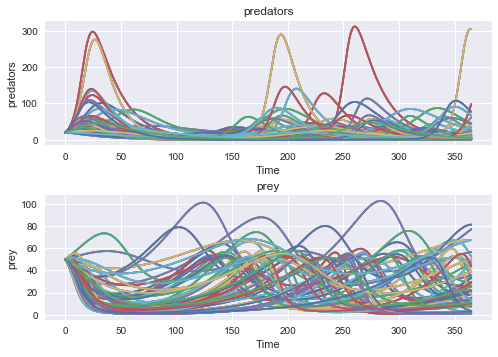

In [24]:
plt.show()

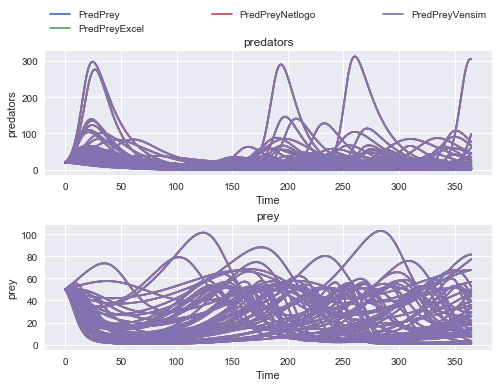

In [25]:
lines(results2, outcomes_to_show=['predators', 'prey'], group_by='model')
plt.show()

In [148]:
# y = outcomes2['predators'][0:50] - outcomes2['predators'][50:100]

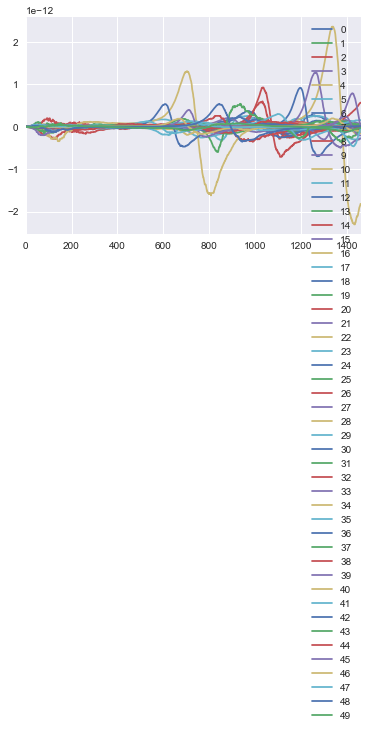

In [151]:
# pd.DataFrame(y).T.plot()

In [155]:
pd.DataFrame.from_records(experiments)['model'].unique()

array(['PredPreyExcel', 'PredPreyNetlogo', 'PredPrey', 'PredPreyVensim'], dtype=object)

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [27]:
outcomes_prey_Excel = outcomes2['predators'][0:50]
outcomes_prey_Netlogo = outcomes2['predators'][50:100]
outcomes_prey_Python = outcomes2['predators'][100:150]
outcomes_prey_Vensim = outcomes2['predators'][150:200]


In [28]:
difExcel = abs(outcomes_prey_Excel - outcomes_prey_Python)
difNetlogo = abs(outcomes_prey_Netlogo - outcomes_prey_Python)
difVensim = abs(outcomes_prey_Vensim - outcomes_prey_Python)

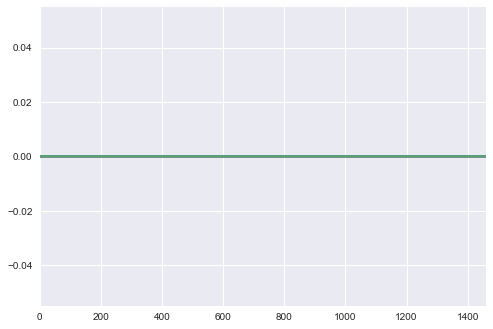

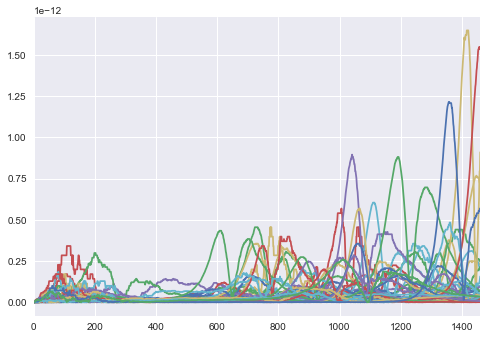

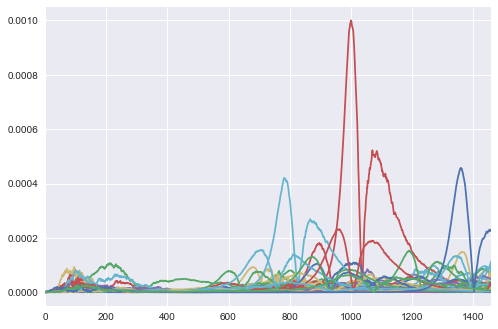

In [31]:
pd.DataFrame(difExcel).T.plot(legend=False)
pd.DataFrame(difNetlogo).T.plot(legend=False)
pd.DataFrame(difVensim).T.plot(legend=False)
plt.show()

In [32]:
a = pd.DataFrame(difExcel).T
b = pd.DataFrame(difNetlogo).T
c = pd.DataFrame(difVensim).T


In [41]:
max(a.mean())

0.0

In [47]:
for x in [a,b,c]:
    print("max mean:", max(x.mean()))
    print("max max:", max(x.max()))

max mean: 0.0
max max: 0.0
max mean: 1.64147348083e-13
max max: 1.64845914696e-12
max mean: 9.26760799015e-05
max max: 0.00100018945409


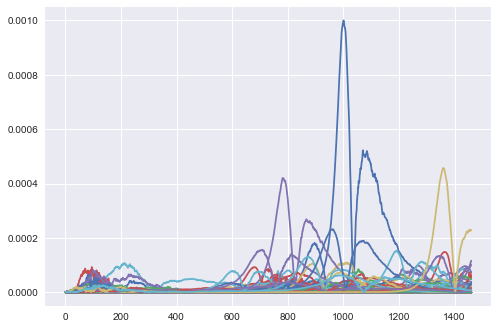

In [34]:
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.show()